In [1]:
from datetime import datetime
import numpy as np 
from matplotlib import pyplot as plt 
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers 
import pandas as pd 

#### Importo il dataset

In [2]:
ds = pd.read_csv(r'C:\Users\claud\Desktop\Python\MASTER CLASS MACHINE LEARNING\moduli\4 modulo\Esercitazioni 4 modulo\data\meteo.csv')
ds.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


#### Creo una colonna chiamata 'Ok' nel caso rispetti le condizioni di temperatura, vento e visibilita sara True in caso contrario False

In [3]:
ds['Ok'] = False 
ds.loc[(ds['Temperature (C)'] > 0) & (ds['Wind Speed (km/h)'] < 14) & (ds['Visibility (km)'] > 15), 'Ok'] = True 

#### Creo un colonna chiamata 'Ok_13' che prende 13 esempi 6 prima e 6 dopo e indica il numero della degli elementi True per ogni N di elementi 

In [4]:
ds['Ok_13'] = ds['Ok'].rolling(13, center=True).sum()

In [5]:
print(len(ds.loc[ds['Ok_13'] == True]))

10249


In [6]:
ds.dropna(inplace = True)

#### Creo un nuovo dataset con le sottoscritte colonne e lo trasformo in una matrice

In [7]:
ds = ds[['Temperature (C)', 'Visibility (km)', 'Wind Speed (km/h)', 'Ok']]

ds = ds.values

In [8]:
ds

array([[7.733333333333334, 9.982, 12.3648, False],
       [8.77222222222222, 9.982, 14.1519, False],
       [10.82222222222222, 9.982, 11.3183, False],
       ...,
       [31.08333333333333, 16.1, 15.504300000000002, False],
       [31.08333333333333, 16.1, 13.894300000000005, True],
       [30.766666666666666, 15.552600000000002, 14.2163, False]],
      dtype=object)

#### Normalizzo i dati 

In [9]:
features = ds[:, :3]
labels = ds[:, 3]

max_features = np.max(features, axis=0)
min_features = np.min(features, axis=0)

features = (features - min_features) / (max_features - min_features)

#### Defionizione di X e Y con fasi temporali 

In [35]:
step = 13 
x = np.zeros((len(features), step, len(features[0])), dtype = 'float32')
y = np.zeros((len(labels), step), dtype = 'float32')

for id in range(0, len(features) - step):
    x[id] = features[id:id + step]
    y[id] = labels[id:id + step]

print(x.shape)
print(y.shape)


(95924, 13, 3)
(95924, 13)


KerasTensor(type_spec=TensorSpec(shape=(None, 8), dtype=tf.float32, name=None), name='dropout_2/Identity:0', description="created by layer 'dropout_2'")


In [18]:
x_train = x[:90000]
y_train = y[:90000]

x_test = x[90000:]
y_test = y[90000:]

#### Scrittura architettura Bidirezionale con LSTM e compilazione modello

In [28]:
inputs = keras.Input(shape=(x_train.shape[1:]))

x = layers.Bidirectional(layers.LSTM(8, return_sequences = True), merge_mode = 'ave')(inputs)
x = layers.Bidirectional(layers.LSTM(8), merge_mode = 'ave')(x)
x = layers.Dense(8, activation = 'swish')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(step, activation = 'sigmoid')(x)
bidirectional_model = keras.Model(inputs, outputs, name = 'bidirectional')
bidirectional_model.summary()
bidirectional_model.compile(keras.optimizers.Adam(), 'mse', metrics = 'binary_accuracy')

Model: "bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 13, 3)]           0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 13, 8)             768       
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 8)                 1088      
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_5 (Dense)             (None, 13)              

#### Addestramento

In [29]:
bidirectional_history = bidirectional_model.fit(x_train, y_train, batch_size=512, epochs=25, validation_data=(x_test, y_test), verbose=2)

Epoch 1/25
176/176 - 10s - loss: 0.1866 - binary_accuracy: 0.7519 - val_loss: 0.2288 - val_binary_accuracy: 0.7104 - 10s/epoch - 55ms/step
Epoch 2/25
176/176 - 2s - loss: 0.1282 - binary_accuracy: 0.8535 - val_loss: 0.1523 - val_binary_accuracy: 0.7104 - 2s/epoch - 14ms/step
Epoch 3/25
176/176 - 3s - loss: 0.0902 - binary_accuracy: 0.8833 - val_loss: 0.1194 - val_binary_accuracy: 0.8392 - 3s/epoch - 14ms/step
Epoch 4/25
176/176 - 3s - loss: 0.0830 - binary_accuracy: 0.8913 - val_loss: 0.1130 - val_binary_accuracy: 0.8386 - 3s/epoch - 18ms/step
Epoch 5/25
176/176 - 3s - loss: 0.0809 - binary_accuracy: 0.8921 - val_loss: 0.1107 - val_binary_accuracy: 0.8403 - 3s/epoch - 19ms/step
Epoch 6/25
176/176 - 3s - loss: 0.0797 - binary_accuracy: 0.8929 - val_loss: 0.1094 - val_binary_accuracy: 0.8411 - 3s/epoch - 19ms/step
Epoch 7/25
176/176 - 3s - loss: 0.0787 - binary_accuracy: 0.8935 - val_loss: 0.1068 - val_binary_accuracy: 0.8456 - 3s/epoch - 19ms/step
Epoch 8/25
176/176 - 3s - loss: 0.0770 

#### Illustrazione risultati di addestramento 

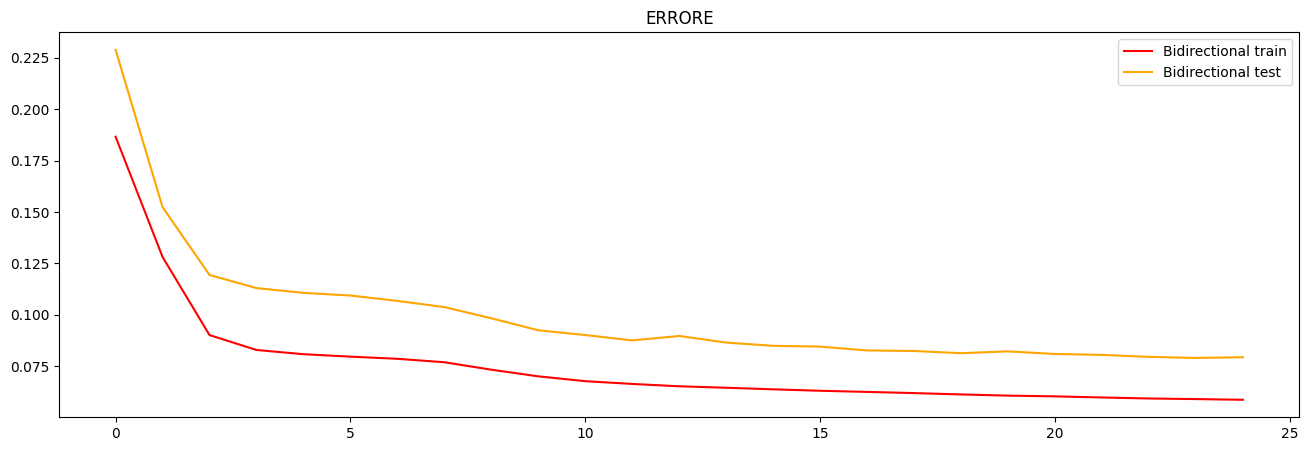

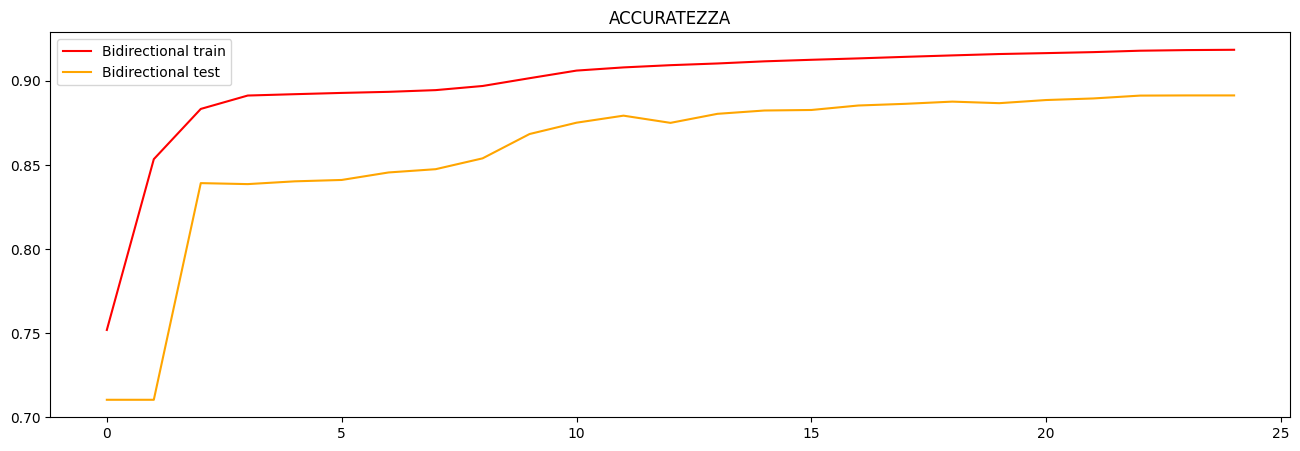

In [30]:
plt.figure(figsize=(16,5))
plt.plot(bidirectional_history.history['loss'], label='Bidirectional train', color='red')
plt.plot(bidirectional_history.history['val_loss'], label='Bidirectional test', color='orange')
plt.title('ERRORE')
plt.legend()
plt.show()

plt.figure(figsize=(16,5))
plt.plot(bidirectional_history.history['binary_accuracy'], label='Bidirectional train', color='red')
plt.plot(bidirectional_history.history['val_binary_accuracy'], label='Bidirectional test', color='orange')
plt.title('ACCURATEZZA')
plt.legend()
plt.show()